In [1]:
!pip install wandb
!pip install 'transformers[torch]'
!pip install datasets 

In [4]:
import wandb
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, confusion_matrix

from transformers import AutoTokenizer, AutoModelForSequenceClassification, default_data_collator, XLMRobertaForSequenceClassification

from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

from IPython.display import clear_output
from datasets import load_dataset, Dataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

2024-04-17 20:12:26.026474: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 20:12:26.026576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 20:12:26.186631: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
def calc_metrics(y_true, y_pred):
    y_true = y_true.cpu()
    y_pred = y_pred.cpu()
    
    res = confusion_matrix(y_true, y_pred).ravel()
    if len(res) == 1:
        if y_true[0] == 0:
            tn, fp, fn, tp = res[0], 0, 0, 0
        else:
            tn, fp, fn, tp = 0, 0, 0, res[0]
    else:
        tn, fp, fn, tp = res
    
    return accuracy_score(y_true, y_pred), precision_score(y_true, y_pred, zero_division=0), recall_score(y_true, y_pred, zero_division=0), f1_score(y_true, y_pred, zero_division=0), tn, fp, fn, tp

@torch.no_grad()
def test(model, loader, device, tqdm_desc):
    loss_log = []
    acc_log = []
    prec_log = []
    rec_log = []
    f1_log = []
    
    tn_log = []
    fp_log = []
    fn_log = []
    tp_log = []
    
    model.eval()
    loss_func = nn.CrossEntropyLoss(weight=torch.tensor([0.73, 0.27]).to(device))

    for input_ids, attention_mask, labels in loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        out = model(input_ids, attention_mask=attention_mask)
        loss = loss_func(out.logits, labels)

        loss_log.append(loss.item())

        pred = torch.argmax(out.logits, dim=1)
        res = calc_metrics(labels, pred)
        acc_log.append(res[0])
        prec_log.append(res[1])
        rec_log.append(res[2])
        f1_log.append(res[3])
        tn_log.append(res[4])
        fp_log.append(res[5])
        fn_log.append(res[6])
        tp_log.append(res[7])

    return loss_log, acc_log, prec_log, rec_log, f1_log, tn_log, fp_log, fn_log, tp_log


def train(model, optimizer, n_epochs, train_loader, val_loader, batch_size, scheduler=None, log_batch_count_train=500, log_batch_count_val=500, preval=True):    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    train_f1 = []
    
    train_tn = []
    train_fp = []
    train_fn = []
    train_tp = []
    
    run = wandb.init(project='xlm-roberta-binclass-2', reinit=True)
    wandb.watch(model, nn.CrossEntropyLoss(weight=torch.tensor([0.73, 0.27]).to(device)), log="all", log_freq=100)
    model.train()

    batch = 0
    loss_func = nn.CrossEntropyLoss(weight=torch.tensor([0.73, 0.27]).to(device))
    
    
    if preval:
        print(f"Init loss:")
        val_loss, val_acc, val_prec, val_rec, val_f1, val_tn, val_fp, val_fn, val_tp = test(model, val_loader, device, tqdm_desc='Validating')
        model.train()

        wandb.log({"val": {"acc": np.mean(val_acc), "pre": np.mean(val_prec), "rec": np.mean(val_rec), "f1": np.mean(val_f1), "loss": np.mean(val_loss), 
                           "true neg": np.mean(val_tn), "false pos": np.mean(val_fp), "false neg": np.mean(val_fn), "true pos": np.mean(val_tp)}})
        
        print(f" val loss: {np.mean(val_loss)}, val acc: {np.mean(val_acc)}\n")
    
    for epoch in range(n_epochs):
        for input_ids, attention_mask, labels in tqdm(train_loader, desc=f'Training {epoch}/{n_epochs}'):
            batch += 1
            
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            out = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = loss_func(out.logits, labels)
            loss.backward()
            optimizer.step()
            
            if batch <= 5:
                proba = F.softmax(out.logits, dim=-1)
                proba = proba.cpu()
                wandb.log({"proba": wandb.Histogram(proba.detach().numpy())})

            train_loss.append(loss.item())

            pred = torch.argmax(out.logits, dim=1)
            res = calc_metrics(labels, pred)
            train_acc.append(res[0])
            train_prec.append(res[1])
            train_rec.append(res[2])
            train_f1.append(res[3])
            train_tn.append(res[4])
            train_fp.append(res[5])
            train_fn.append(res[6])
            train_tp.append(res[7])
            
            # train log
            if batch % log_batch_count_train == 0:
                wandb.log({"train": {"acc": np.mean(train_acc), "pre": np.mean(train_prec), "rec": np.mean(train_rec), "f1": np.mean(train_f1), "loss": np.mean(train_loss), 
                                     "true neg": np.mean(train_tn), "false pos": np.mean(train_fp), "false neg": np.mean(train_fn), "true pos": np.mean(train_tp)}})
                
                # clear_output()
                train_loss = []
                train_acc = []
                train_prec = []
                train_rec = []
                train_f1 = []
                train_tn = []
                train_fp = []
                train_fn = []
                train_tp = []
            
            # test log
            if batch % log_batch_count_val == 0:
                val_loss, val_acc, val_prec, val_rec, val_f1, val_tn, val_fp, val_fn, val_tp = test(model, val_loader, device, tqdm_desc='Validating')
                model.train()
                
                wandb.log({"val": {"acc": np.mean(val_acc), "pre": np.mean(val_prec), "rec": np.mean(val_rec), "f1": np.mean(val_f1), "loss": np.mean(val_loss), 
                                   "true neg": np.mean(val_tn), "false pos": np.mean(val_fp), "false neg": np.mean(val_fn), "true pos": np.mean(val_tp)}})

        if scheduler is not None:
            scheduler.step()
            
    # последние батчи
    val_loss, val_acc, val_prec, val_rec, val_f1, val_tn, val_fp, val_fn, val_tp = test(model, val_loader, device, tqdm_desc='Validating')
                
    wandb.log({"train": {"acc": np.mean(train_acc), "pre": np.mean(train_prec), "rec": np.mean(train_rec), "f1": np.mean(train_f1), "loss": np.mean(train_loss), 
                         "true neg": np.mean(train_tn), "false pos": np.mean(train_fp), "false neg": np.mean(train_fn), "true pos": np.mean(train_tp)}, 
                "val": {"acc": np.mean(val_acc), "pre": np.mean(val_prec), "rec": np.mean(val_rec), "f1": np.mean(val_f1), "loss": np.mean(val_loss), 
                        "true neg": np.mean(val_tn), "false pos": np.mean(val_fp), "false neg": np.mean(val_fn), "true pos": np.mean(val_tp)}})
    print(f"Last batches:")
    print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
    print(f" val loss: {np.mean(val_loss)}, val acc: {np.mean(val_acc)}\n")

    wandb.unwatch()
    run.finish()

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [7]:
wandb.login(key="eba16103be2afd0b5c96243771d60f5d7e562f68")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# **Обрабатываем данные**

In [6]:
table_path = "/kaggle/input/site-bin-class/pars_data.csv"
data = pd.read_csv(table_path, on_bad_lines='skip', sep=';', lineterminator='\n')
data.dropna(axis=0, how='any', inplace=True)
data.text = data.text.astype(str)

dataset = Dataset.from_pandas(data)

In [6]:
data.head()

,text,target
0,индивидуальные групповые занятия будни выходны...,1
1,royal life федеральное театральное агентство «...,0
2,автоматизированная система uontravel войти заб...,0
3,уходовая домашняя косметика для души тела зада...,0
4,новости обучение трейдингу нуля обучение трейд...,1


In [9]:
print('общий размер датасета', data.shape[0])
print('количество элементов не из образования', data[data['target'] == 0]['text'].count())
print('количество элементов из образования', data[data['target'] == 1]['text'].count())
print('максимальный размер строки в датасете', max(len(i) for i in data['text']))

общий размер датасета 47621
количество элементов не из образования 34656
количество элементов из образования 12965
максимальный размер строки в датасете 1339641


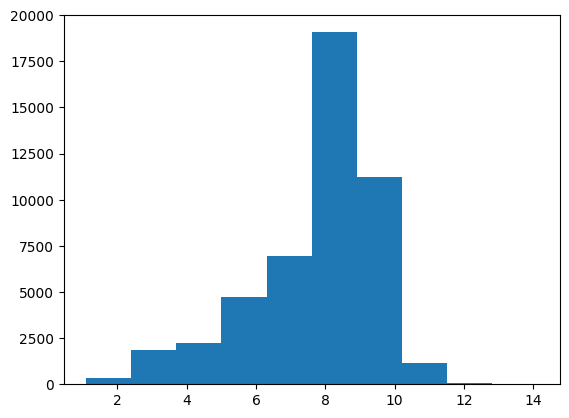

In [11]:
# гистог по лог от размера строки

plt.hist(np.log([len(i) for i in data['text']]))
plt.show()

In [14]:
np.exp(10)

22026.465794806718

In [36]:
def write_to_file(df, cut_size, rows_count):
    text = df['text'].tolist()
    with open(f"first_{cut_size}.txt", "w", encoding='utf-8') as f:
        for i in range(rows_count):
            target = df.iloc[i, 1]
            f.write(f'{i} target: {target}, text: ' + text[i][:cut_size] + '\n\n')

In [37]:
write_to_file(data, 512, data.shape[0])

In [38]:
write_to_file(data, 3000, 3)

# **Инициализируем модель и токенайзер (обрабатываем текст)**

In [8]:
# Load model directly

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
model = XLMRobertaForSequenceClassification.from_pretrained("FacebookAI/xlm-roberta-base").to(device)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
%%time

TEST_SIZE = 0.3
SPLIT_RANDOM_SEED = 42
MAX_LENGTH = 512

def encode(examples):
    result = tokenizer(examples["text"], truncation=True, max_length=MAX_LENGTH, padding="max_length")
    return result

tokenized_datasets = dataset.map(encode, batched=True, remove_columns="text")

  0%|          | 0/48 [00:00<?, ?ba/s]

CPU times: user 9min 5s, sys: 2.06 s, total: 9min 7s
Wall time: 2min 39s


In [9]:
%%time


input_ids_train, input_ids_v, attention_mask_train, attention_mask_v, label_train, label_v = train_test_split(torch.tensor(tokenized_datasets['input_ids']), 
                                                                                                  torch.tensor(tokenized_datasets['attention_mask']), 
                                                                                                  torch.tensor(tokenized_datasets['target']), 
                                                                                                  random_state=SPLIT_RANDOM_SEED, test_size=TEST_SIZE, shuffle=True)

input_ids_val, input_ids_test, attention_mask_val, attention_mask_test, label_val, label_test = train_test_split(input_ids_v, attention_mask_v, label_v, 
                                                                                                  random_state=SPLIT_RANDOM_SEED, test_size=0.33, shuffle=True)

train_dataset = TensorDataset(input_ids_train, attention_mask_train, label_train)
val_dataset = TensorDataset(input_ids_val, attention_mask_val, label_val)
test_dataset = TensorDataset(input_ids_test, attention_mask_test, label_test)

CPU times: user 55.3 s, sys: 835 ms, total: 56.2 s
Wall time: 55.6 s


In [10]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **Базовая модель (512 размер строки)**

In [12]:
optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=3e-10)
train(model, optimizer, 3, train_loader, val_loader, batch_size, scheduler, 500, True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ···············


wandb: ERROR API key must be 40 characters long, yours was 15
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ··············


wandb: ERROR API key must be 40 characters long, yours was 14
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Init loss:
 val loss: 0.7631489169816541, val acc: 0.27013772954924875



Training 2/3: 100%|██████████| 2084/2084 [1:17:35<00:00,  2.23s/it]   


Last batches:
 train loss: 0.17207644524289264, train acc: 0.8873181216931216
 val loss: 0.17492018614076266, val acc: 0.8910684474123539



In [13]:
test_loss, test_acc, test_prec, test_rec, test_f1 = test(model, test_loader, device, tqdm_desc='Test')
print(f'loss = {np.mean(test_loss)}, accuracy = {np.mean(test_acc)}, precision = {np.mean(test_prec)}, recall = {np.mean(test_rec)}, f1_score = {np.mean(test_f1)}')

loss = 0.22772546339211827, accuracy = 0.9044491525423729, precision = 0.8426836158192089, recall = 0.7995466774280334, f1_score = 0.798695709903665


# **Поставим AdamW**

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=3e-10)
train(model, optimizer, 3, train_loader, val_loader, batch_size, scheduler, 500, True)

wandb: Currently logged in as: rodion-chernomordin. Use `wandb login --relogin` to force relogin


Init loss:
 val loss: 0.8206590203092572, val acc: 0.27013772954924875



Training 0/3:  84%|████████▍ | 1757/2084 [1:04:02<08:20,  1.53s/it]  

In [14]:
test_loss, test_acc, test_prec, test_rec, test_f1, _, _, _, _ = test(model, test_loader, device, tqdm_desc='Test')
print(f'loss = {np.mean(test_loss)}, accuracy = {np.mean(test_acc)}, precision = {np.mean(test_prec)}, recall = {np.mean(test_rec)}, f1_score = {np.mean(test_f1)}')

loss = 0.1482858021790951, accuracy = 0.9114406779661017, precision = 0.9117056766209308, recall = 0.7388350820554209, f1_score = 0.7947826508964149


# **Убираем Weight Decay**

In [11]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=2e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=3e-10)
train(model, optimizer, 3, train_loader, val_loader, batch_size, scheduler, 500, True)

wandb: Currently logged in as: rodion-chernomordin. Use `wandb login --relogin` to force relogin


Init loss:
 val loss: 0.6089233196836481, val acc: 0.7298622704507512



Training 2/3: 100%|██████████| 2084/2084 [1:21:17<00:00,  2.34s/it]   


Last batches:
 train loss: 0.12629906724517545, train acc: 0.917906746031746
 val loss: 0.16067972967015556, val acc: 0.9071368948247078



In [12]:
test_loss, test_acc, test_prec, test_rec, test_f1, _, _, _, _ = test(model, test_loader, device, tqdm_desc='Test')
print(f'loss = {np.mean(test_loss)}, accuracy = {np.mean(test_acc)}, precision = {np.mean(test_prec)}, recall = {np.mean(test_rec)}, f1_score = {np.mean(test_f1)}')

loss = 0.15276203339730027, accuracy = 0.9116525423728814, precision = 0.8944404089319343, recall = 0.7478732849071832, f1_score = 0.7933718356704661


# **Логируем каждый батч, но одну эпоху (иначе умру) - полная модель с парам лоссом**

In [11]:
%%time

optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=3e-10)
train(model, optimizer, 1, train_loader, val_loader, batch_size, scheduler, 1, 100, True)

wandb: Currently logged in as: rodion-chernomordin. Use `wandb login --relogin` to force relogin


Init loss:
 val loss: 0.732394598163229, val acc: 0.27013772954924875



Training 0/1: 100%|██████████| 2084/2084 [2:54:59<00:00,  5.04s/it]    
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Last batches:
 train loss: nan, train acc: nan
 val loss: 0.1626481899730426, val acc: 0.8773998330550918



CPU times: user 3h 12min 3s, sys: 10min 30s, total: 3h 22min 33s
Wall time: 3h 7min 6s


# **Проверка на переобучение**

In [11]:
input_ids_train, input_ids_v, attention_mask_train, attention_mask_v, label_train, label_v = train_test_split(torch.tensor(tokenized_datasets['input_ids']), 
                                                                                                  torch.tensor(tokenized_datasets['attention_mask']), 
                                                                                                  torch.tensor(tokenized_datasets['target']), 
                                                                                                  random_state=SPLIT_RANDOM_SEED, test_size=TEST_SIZE, shuffle=True)

input_ids_val, input_ids_test, attention_mask_val, attention_mask_test, label_val, label_test = train_test_split(input_ids_v, attention_mask_v, label_v, 
                                                                                                  random_state=SPLIT_RANDOM_SEED, test_size=0.33, shuffle=True)

In [12]:
new_train_size = 1024

print(input_ids_train.shape)
input_ids_train, attention_mask_train, label_train = input_ids_train[:new_train_size], attention_mask_train[:new_train_size], label_train[:new_train_size]
print(input_ids_train.shape)

torch.Size([33334, 512])
torch.Size([1024, 512])


In [13]:
train_dataset = TensorDataset(input_ids_train, attention_mask_train, label_train)
val_dataset = TensorDataset(input_ids_val, attention_mask_val, label_val)
test_dataset = TensorDataset(input_ids_test, attention_mask_test, label_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
%%time

optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=3e-10)
train(model, optimizer, 3, train_loader, val_loader, batch_size, scheduler, 10, True)

wandb: Currently logged in as: rodion-chernomordin. Use `wandb login --relogin` to force relogin


Init loss:
 val loss: 0.7494236751271409, val acc: 0.27013772954924875



Training 2/3: 100%|██████████| 64/64 [41:26<00:00, 38.85s/it]   


Last batches:
 train loss: 0.213849738240242, train acc: 0.8125
 val loss: 0.27180532853621275, val acc: 0.7298622704507512



CPU times: user 2h 10min 52s, sys: 5min 18s, total: 2h 16min 10s
Wall time: 2h 4min 54s


In [15]:
test_loss, test_acc, test_prec, test_rec, test_f1, _, _, _, _ = test(model, test_loader, device, tqdm_desc='Test')
print(f'loss = {np.mean(test_loss)}, accuracy = {np.mean(test_acc)}, precision = {np.mean(test_prec)}, recall = {np.mean(test_rec)}, f1_score = {np.mean(test_f1)}')

loss = 0.27651061839976554, accuracy = 0.7283127889060093, precision = 0.0, recall = 0.0, f1_score = 0.0


# **Попробуем новый (обработанный) датасет**

In [18]:
table_path = "/kaggle/input/course-work/processed_data.csv"
data = pd.read_csv(table_path)
data.dropna(axis=0, how='any', inplace=True)
data.text = data.text.astype(str)

dataset = Dataset.from_pandas(data)

In [9]:
data.head()

,text,target
0,курс школа маникюр ногтевой ученик сервис обуч...,1
1,билет купить руб подробный звезда февраль влад...,0
2,войти условие свой персональный данные автомат...,0
3,крем мыло свеча косметика благовоние душа адре...,0
4,трейдинг обучение показать profitteam просмотр...,1


In [19]:
print('общий размер датасета', data.shape[0])
print('количество элементов не из образования', data[data['target'] == 0]['text'].count())
print('количество элементов из образования', data[data['target'] == 1]['text'].count())
print('максимальный размер строки в датасете', max(len(i) for i in data['text']))

общий размер датасета 47561
количество элементов не из образования 34615
количество элементов из образования 12946
максимальный размер строки в датасете 512


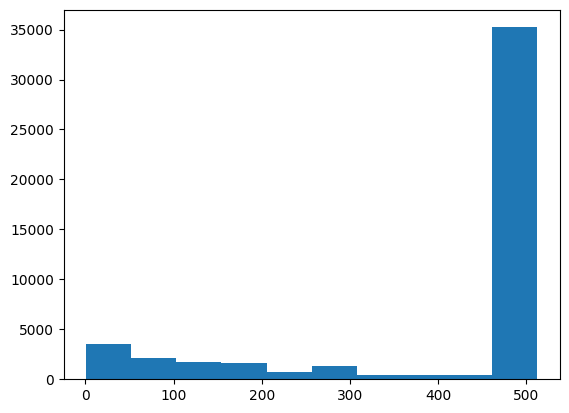

In [11]:
# гистог по лог от размера строки

plt.hist([len(i) for i in data['text']])
plt.show()

In [10]:
%%time

TEST_SIZE = 0.3
SPLIT_RANDOM_SEED = 42
MAX_LENGTH = 512

def encode(examples):
    result = tokenizer(examples["text"], truncation=True, max_length=MAX_LENGTH, padding="max_length")
    return result

tokenized_datasets = dataset.map(encode, batched=True, remove_columns="text")

Map:   0%|          | 0/47561 [00:00<?, ? examples/s]

CPU times: user 41.7 s, sys: 386 ms, total: 42.1 s
Wall time: 20.6 s


In [ ]:
%%time


input_ids_train, input_ids_v, attention_mask_train, attention_mask_v, label_train, label_v = train_test_split(torch.tensor(tokenized_datasets['input_ids']), 
                                                                                                  torch.tensor(tokenized_datasets['attention_mask']), 
                                                                                                  torch.tensor(tokenized_datasets['target']), 
                                                                                                  random_state=SPLIT_RANDOM_SEED, test_size=TEST_SIZE, shuffle=True)

input_ids_val, input_ids_test, attention_mask_val, attention_mask_test, label_val, label_test = train_test_split(input_ids_v, attention_mask_v, label_v, 
                                                                                                  random_state=SPLIT_RANDOM_SEED, test_size=0.33, shuffle=True)

train_dataset = TensorDataset(input_ids_train, attention_mask_train, label_train)
val_dataset = TensorDataset(input_ids_val, attention_mask_val, label_val)
test_dataset = TensorDataset(input_ids_test, attention_mask_test, label_test)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=2e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=3e-10)
train(model, optimizer, 3, train_loader, val_loader, batch_size, scheduler, 500, 500, True)

In [14]:
test_loss, test_acc, test_prec, test_rec, test_f1, _, _, _, _ = test(model, test_loader, device, tqdm_desc='Test')
print(f'loss = {np.mean(test_loss)}, accuracy = {np.mean(test_acc)}, precision = {np.mean(test_prec)}, recall = {np.mean(test_rec)}, f1_score = {np.mean(test_f1)}')

loss = 0.15373543328368816, accuracy = 0.9127118644067796, precision = 0.8600968523002421, recall = 0.7594538606403013, f1_score = 0.7859078558530204


# **Чистка памяти**

In [16]:
import gc
torch.cuda.empty_cache()
gc.collect()

0